# Noise in the wavelet domain

Lets assume that an evolutionary spectrum is given by

$S(t, f) = S_{n}(f) \left(1 + \alpha \cos(2 \pi f_0 t)\right)^2$

We use the LISA PSD as the noise spectrum $S_{n}(f)$ and we assume that the noise is modulated by a cosine function with amplitude $A$, frequency $f_0$.



## 1. Imports + Magic

In [168]:

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pywavelet.utils.lisa import lisa_psd, periodogram, generate_noise, TimeSeries


DATA_COL = "tab:gray"
TRUE_COL = "tab:orange"

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Generate data

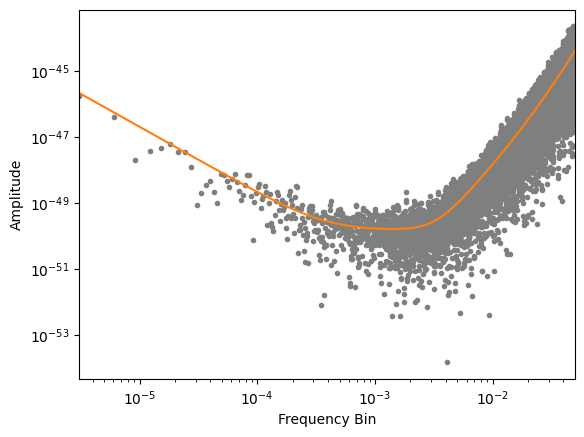

In [167]:
tmax = 120 * 60 * 60  # Final time
fs = 0.1  # Sampling rate
delta_t = 1 / fs  # Sampling interval -- largely oversampling here.
n_data = 2 ** int(np.log(tmax / delta_t) / np.log(2))
data = generate_noise(lisa_psd, n_data=n_data, fs=fs, tmax=tmax)

prdgm = periodogram(data)
true_psd = lisa_psd(prdgm.freq)

fig = prdgm.plot(rasterized=True, marker=".", lw=0, color=DATA_COL)
_ = fig.get_axes()[0].plot(prdgm.freq, true_psd, color=TRUE_COL)
_ = fig.get_axes()[0].set_xlim(prdgm.freq[1], prdgm.freq.max())

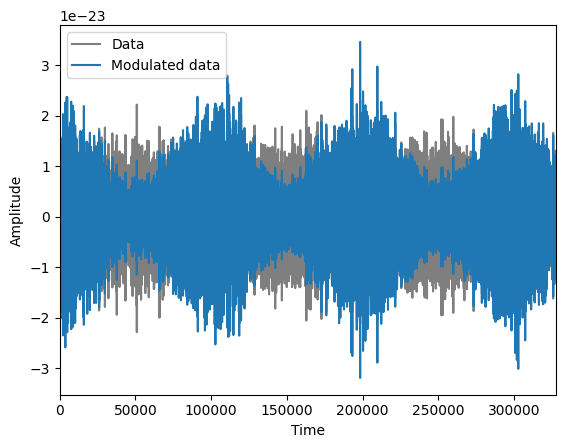

In [173]:
# Apply a modulation to this noise
A_TRUE = 1.0  # 5e-21
F_TRUE = 1e-5
ALPHA_TRUE = 0.5

modulation = lambda t: A_TRUE * (
    1 + ALPHA_TRUE * np.cos(2 * np.pi * F_TRUE * t)
)
data_modulated = TimeSeries(
    data=data.data * modulation(data.time), time=data.time
)

fig = data.plot(rasterized=True, color=DATA_COL, label="Data")
ax = fig.get_axes()[0]
fig = data_modulated.plot(
    ax=ax, rasterized=True, color="tab:blue", label="Modulated data"
)
_ = ax.set_xlim(data.time.min(), data.time.max())
_ = ax.legend()

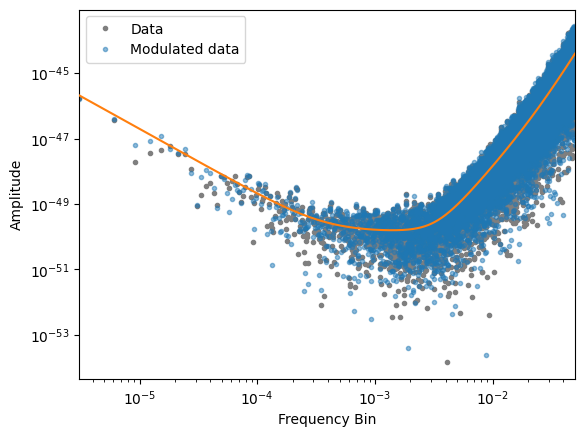

In [178]:
prdgm_modulated = periodogram(data_modulated)

fig = prdgm.plot(
    rasterized=True, marker=".", lw=0, color=DATA_COL, label="Data"
)
ax = fig.get_axes()[0]
prdgm_modulated.plot(
    ax=ax,
    rasterized=True,
    color="tab:blue",
    label="Modulated data",
    marker=".",
    lw=0,
    alpha=0.5,
)
_ = ax.plot(prdgm.freq, true_psd, color=TRUE_COL, zorder=10)
_ = ax.set_xlim(prdgm.freq[1], prdgm.freq.max())
_ = ax.legend()

## 3. Build frequency-domain analytical spectrum

In [185]:
from pywavelet.transforms import from_time_to_wavelet
from pywavelet.transforms.types import Wavelet

# Size of the data
ND = len(prdgm_modulated)
tobs = prdgm_modulated.duration
# timeseries = TimeSeries(data=data_noise_mod, time=tobs)
# We know that the data varies slowly with f_true
# The durations where the process is approximately stationary should be
# much smaller than t_true = 1/f_true
# If we pick dt = t_true / 10

q = int(np.log(n_data) / np.log(2))
qf = int(q / 2) + 1
Nf = 2 ** (qf)
Nt = 2 ** (q - qf)

mult = 32
K = mult * 2 * Nf

# Here are
df = Nt / (2 * tobs)
dt = tobs / Nt

print(
    f"Duration which the process is approximately stationary is {1 / F_TRUE / 10:.2f}"
)
print(f"ND: {ND}, Nf: {Nf}, Nt: {Nt}, Nf * Nt: {Nf * Nt}")
print(f"dt={dt}, df={df}")

Duration which the process is approximately stationary is 10000.00
ND: 16384, Nf: 256, Nt: 128, Nf * Nt: 32768
dt=2560.0, df=0.0001953125


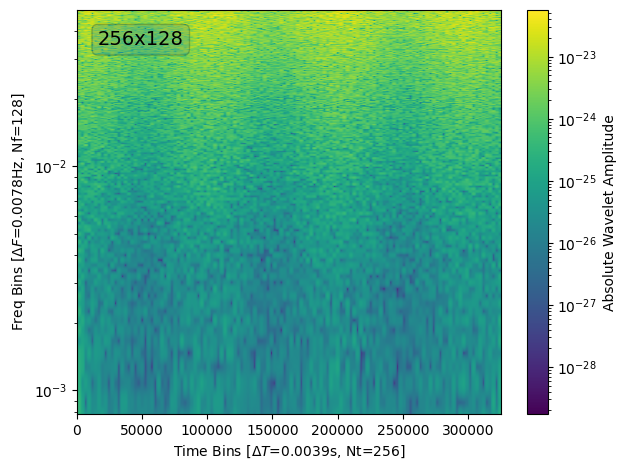

In [191]:
data_wavelet = from_time_to_wavelet(data_modulated, Nt=Nt, nx=4.0, mult=mult)
fig = data_wavelet.plot(
    absolute=True, zscale="log", freq_scale="log", freq_range=(4 * df, None)
)

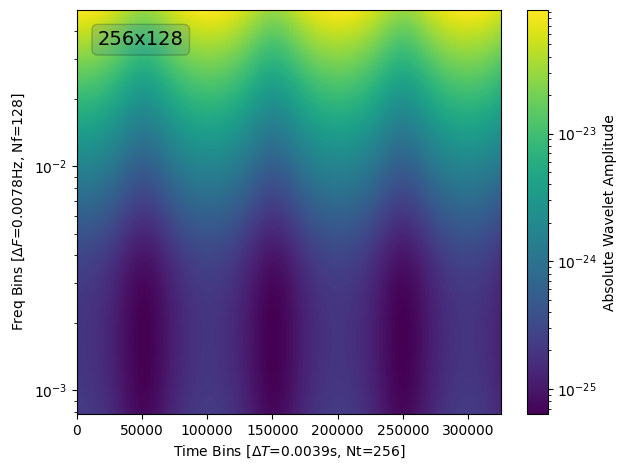

In [193]:
tn = data_wavelet.time.data
fm = data_wavelet.freq.data
stf = np.sqrt(
    np.dot(np.asarray([modulation(tn) ** 2]).T, np.asarray([lisa_psd(fm)]))
).T
analytical_wavelet = Wavelet.new(data=stf, time=tn, freq=fm)
fig = analytical_wavelet.plot(
    absolute=True, zscale="log", freq_scale="log", freq_range=(4 * df, None)
)

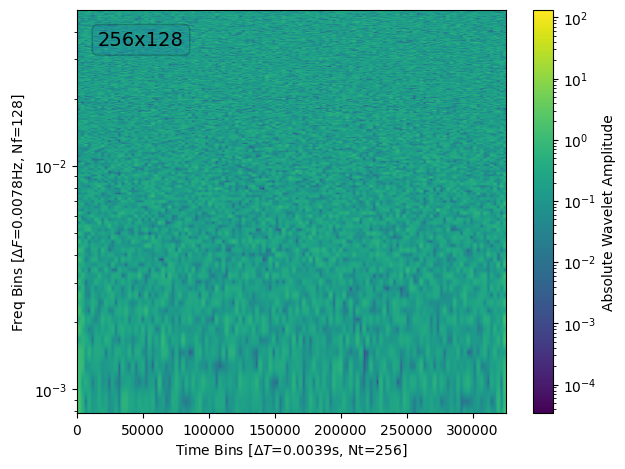

In [194]:
# Try to weight the data
ratios = np.sqrt(
    np.abs(data_wavelet.data) ** 2 / np.abs(analytical_wavelet.data) ** 2
)
ratios = Wavelet.new(data=ratios, time=tn, freq=fm)
fig = ratios.plot(
    absolute=True, zscale="log", freq_scale="log", freq_range=(4 * df, None)
)

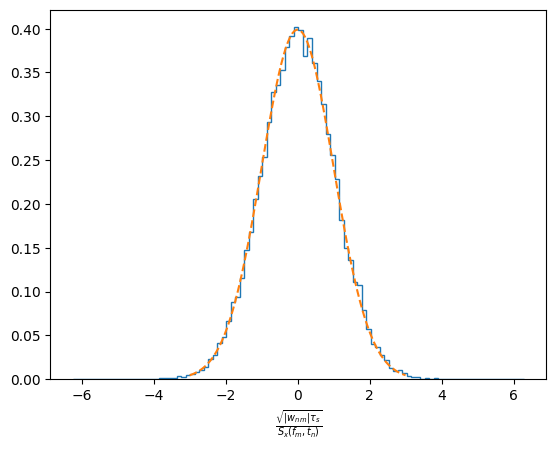

In [195]:
iok = np.where(fm >= 4 * df)

# filter the data_noise_mod_w and the analytical_wavelet frequencies to keep only the positive frequencies
d = data_wavelet.data[iok, :]
a = analytical_wavelet.data[iok, :] ** 2
amp_ratios = d / np.sqrt(a * fs / 2)

# plot the ratios
x = np.linspace(-3, 3, 100)
plt.figure(0)
plt.hist(
    amp_ratios.flatten(), density=True, bins=100, histtype="step"
)  # , range=[0, 0.5])
plt.plot(x, stats.norm.pdf(x), ls="--")
plt.xlabel(r"$\frac{\sqrt{|w_{nm}| \tau_s}}{S_{x}(f_m, t_n)}$")
plt.show()